## Load the pre-trained word2vec model from the fake PII data. 

First, load the packages.

In [1]:
from gensim.models import Word2Vec
import pandas as pd

Load the word2vec model and the fake pii text with labels.

In [55]:
word2vec = Word2Vec.load("./word2vec/word2vec_300_fake_pii.bin")

In [3]:
fake_pii = pd.read_csv("../data/text_with_pii_2018_12_21_04_32_47_173911.csv")

# clean the text in a sentence and return a sentence.
def clean_sentence(sentence):
    
    sentence_cleaned = [word.replace(",", "").replace(".", "")\
                        .lower() for word in sentence.split(" ")]
    return " ".join(sentence_cleaned)    

context_sentences = fake_pii["Text"].apply(clean_sentence)

What the data look like?

In [4]:
fake_pii.head(10)

,Text,Labels,PII
0,Ever watch television read measure almost. Tho...,Address,Suite 971
1,Impact region card 37271 Adams Road Suite 438 ...,Address,37271 Adams Road Suite 438
2,0604 Mason Wall Throughout admit have science ...,Address,0604 Mason Wall
3,Able item bag my day impact continue. Apt. 633...,Address,Apt. 633
4,Inside perhaps Suite 744 else seven. Able seas...,Address,Suite 744
5,Feeling more reduce everything. Apt. 524 Creat...,Address,Apt. 524
6,Rule price recognize continue. Happy act agree...,Address,22471 Hannah Crossing
7,Suite 104 Some second dinner. Force past line ...,Address,Suite 104
8,"Large 930 Chad Ford Apt. 029 New Michaelmouth,...",Address,"930 Chad Ford Apt. 029 New Michaelmouth, KY 89394"
9,Future movement office. Thus building successf...,Address,"0874 Charles Forge Suite 659 Caitlinburgh, ME ..."


Take a look at the dimensions of the data.

In [5]:
fake_pii.shape

(800000, 3)

Let us take a look at one example of the data.

In [6]:
fake_pii.iloc[300001,0]

'Impact region card technology indicate. Station cut rule Patricia Smith church Congress. There west parent write. Accept image region through group matter.'

In [7]:
result_text = context_sentences[300001].split()

result_text

['impact',
 'region',
 'card',
 'technology',
 'indicate',
 'station',
 'cut',
 'rule',
 'patricia',
 'smith',
 'church',
 'congress',
 'there',
 'west',
 'parent',
 'write',
 'accept',
 'image',
 'region',
 'through',
 'group',
 'matter']

Let us see what is the most dissimilar word in the above list.

In [8]:
word2vec.wv.doesnt_match(result_text)

'patricia'

## Visualize word2vec embedding in 2d 

The next goal is to generate the embedding for the part of the PII. 

In [9]:
def find_part_pii(text, model, sep = " "):
    tokenized_text = text.split(sep)
    
    part_pii = model.wv.doesnt_match(tokenized_text)
    
    return part_pii    

In [10]:
from tqdm import tqdm
pii_list = [find_part_pii(text, model = word2vec) for text in tqdm(context_sentences) ]

100%|██████████| 800000/800000 [01:22<00:00, 9707.25it/s] 


In [11]:
import numpy as np
from tqdm import tqdm

def get_pii2vec_matrix(pii_list, model):
    # set the matrix dimensions
    column_num = model.trainables.layer1_size
    row_num = len(pii_list)
    # initialized the matrix
    pii2vec_mat = np.zeros((row_num, column_num))
    # iterate through the pii_list and assign the vectors to matrix.
    for index, ith_pii in enumerate(tqdm(pii_list)):
        pii2vec_mat[index,:] = model.wv[ith_pii]
    
    return pii2vec_mat

In [12]:
pii_matrix = get_pii2vec_matrix(pii_list = pii_list, model = word2vec)

100%|██████████| 800000/800000 [00:03<00:00, 210926.92it/s]


In [13]:
pii_labels = fake_pii["Labels"]

Visualize the resulting matrix with PCA in 2 dimensions. 

In [14]:
from yellowbrick.features.pca import PCADecomposition
import matplotlib.pyplot as plt

In [15]:
pii_labels.value_counts()

Phone_number        100000
SSN                 100000
Email               100000
Address             100000
Name                100000
Plates              100000
CreditCardNumber    100000
None                100000
Name: Labels, dtype: int64

In [16]:
color_dict = {"Phone_number":"red","SSN":"blue","Address":"black","Name":"yellow",\
             "Plates":"orange","CreditCardNumber":"purple","None":'pink',"Email":"tan"}

colors = pii_labels.map(color_dict)

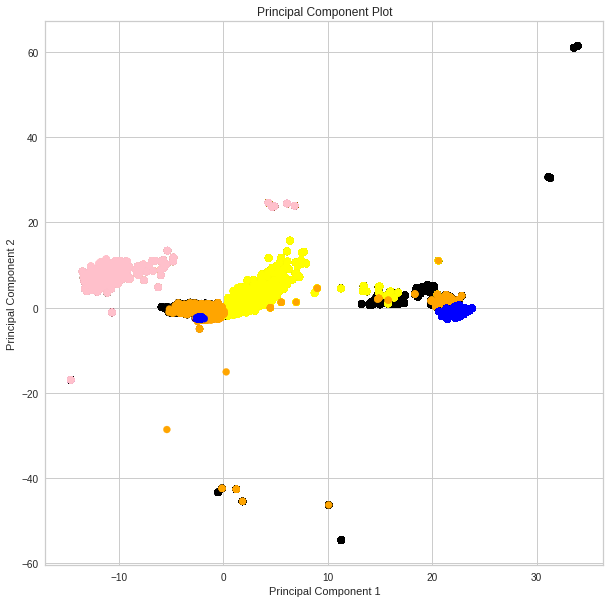

CPU times: user 54.4 s, sys: 9.34 s, total: 1min 3s
Wall time: 50.3 s


In [17]:
%%time 

plt.figure(figsize=(10,10))
PCAvisualizer = PCADecomposition(scale=True, color = colors, proj_dim = 2)
PCAvisualizer.fit_transform(pii_matrix, pii_labels)
PCAvisualizer.poof()

The color and PII type are related as 
{"Phone_number":"red","SSN":"blue","Address":"black","Name":"yellow",\
             "Plates":"orange","CreditCardNumber":"purple","None":'pink',"Email":"tan"}

### The Pink is the non-PII data and others are different types of PII. A Logistic regression can have a good performance on seprating the PII vs non-PII data.

## Try a logistic regression classifier for performance. 

Train a Logistic regression to classify different PIIs and non-PII text. 

In [18]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, expon

from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression


In [19]:
fake_pii["Extracted_PII"] = pii_list

In [20]:
# %%time 
# pipe = make_pipeline(StandardScaler(), PCA(n_components= 10),\
#                      LogisticRegression(random_state=7, multi_class='multinomial',solver='lbfgs',max_iter=10000))
# param_grid = {
#     "logisticregression__C": expon(scale=2),
#     "logisticregression__penalty": ['l1','l2']
# }

# pipe.fit(pii_matrix, fake_pii["Labels"])
# random_cv = RandomizedSearchCV(pipe,param_grid, cv = 10, n_jobs = 2,
#                                n_iter = 10 , error_score = 0, 
#                                return_train_score=True, scoring = 'f1')

In [21]:
%%time

from sklearn.linear_model import LogisticRegression

lr_multi = LogisticRegression(random_state=0, multi_class='multinomial',solver='lbfgs',max_iter=10000)

lr_multi.fit(pii_matrix, fake_pii["Labels"])


CPU times: user 31min, sys: 5min 36s, total: 36min 36s
Wall time: 12min 20s


In [22]:
prediction = lr_multi.predict(pii_matrix)

In [23]:
def binary_pii(label):
    pii_label = "No"
    if label != "None":
        pii_label = "Yes"
    return pii_label 
        
binary_true = [binary_pii(label) for label in fake_pii["Labels"]]

binary_pred = [binary_pii(label) for label in prediction]

In [24]:
from sklearn.metrics import f1_score

In [25]:
from sklearn.metrics import confusion_matrix

In [26]:
binary_true = pd.Series(binary_true)
binary_true.value_counts()

Yes    700000
No     100000
dtype: int64

In [27]:
binary_pred = pd.Series(binary_pred)
binary_pred.value_counts()

Yes    689050
No     110950
dtype: int64

Text(33,0.5,'True values')

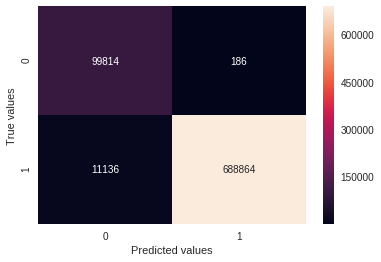

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(confusion_matrix(y_true = binary_true, y_pred = binary_pred), annot = True,fmt="d")
plt.xlabel("Predicted values")
plt.ylabel("True values")

Text(114,0.5,'True values')

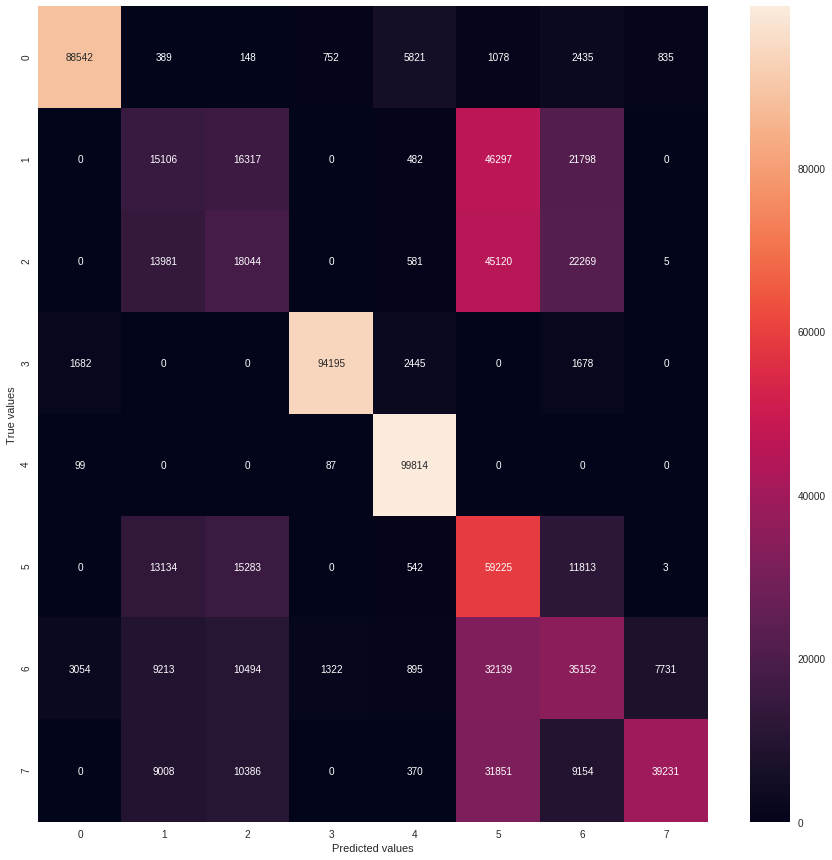

In [29]:
plt.figure(figsize = (15,15))
sns.heatmap(confusion_matrix(y_true = fake_pii["Labels"], y_pred = prediction), annot = True,fmt="d")
plt.xlabel("Predicted values")
plt.ylabel("True values")

## The non-PII vs PII binary classification result. 

In [30]:
from sklearn.metrics import classification_report

In [31]:
%%time
print(classification_report(y_true = binary_true, y_pred = binary_pred))

              precision    recall  f1-score   support

          No       0.90      1.00      0.95    100000
         Yes       1.00      0.98      0.99    700000

   micro avg       0.99      0.99      0.99    800000
   macro avg       0.95      0.99      0.97    800000
weighted avg       0.99      0.99      0.99    800000

CPU times: user 21.3 s, sys: 7.52 ms, total: 21.3 s
Wall time: 21.3 s


##  The multi-class PII classification result.

In [32]:
%%time
print(classification_report(y_true = fake_pii["Labels"], y_pred = prediction))

                  precision    recall  f1-score   support

         Address       0.95      0.89      0.92    100000
CreditCardNumber       0.25      0.15      0.19    100000
           Email       0.26      0.18      0.21    100000
            Name       0.98      0.94      0.96    100000
            None       0.90      1.00      0.95    100000
    Phone_number       0.27      0.59      0.38    100000
          Plates       0.34      0.35      0.34    100000
             SSN       0.82      0.39      0.53    100000

       micro avg       0.56      0.56      0.56    800000
       macro avg       0.60      0.56      0.56    800000
    weighted avg       0.60      0.56      0.56    800000

CPU times: user 15.8 s, sys: 10.2 ms, total: 15.8 s
Wall time: 15.8 s


The model achieves a pretty good performance on binary classification of text with/without PII as expected from the PCA visualizer. A much better model can be trained to deal with better performance among recognizing different PII types. 

### But a more important problem to solve was how to generalize the trained model to perform on unseen data if  the model has not seen this specific PII data before. 

## Import some new fake data and test to see if it works on email data. 

In [45]:
new_data = pd.read_csv('../data/text_with_pii_2018_12_28_11_08_49_371014.csv')
word2vec_new = Word2Vec.load("./word2vec/word2vec_300_fake_pii.bin")

In [46]:
email_pii_copy = new_data[new_data.Labels == "Email"].copy()

In [47]:
email_pii_copy["Text"] = email_pii_copy['Text'].apply(clean_sentence)

In [48]:
email_pii_copy['Text'].iloc[1]

'agreement threat conference audience goal billion green yeah wrhodes@santiagocom couple pressure wrong play analysis push even great'

In [49]:
email_pii_text = list(email_pii_copy['Text'].values)

In [50]:
tokenized_email_pii_text = [email_pii.split(" ") for email_pii in email_pii_text] 

In [51]:
len(tokenized_email_pii_text)

1000

In [52]:
word2vec_new.build_vocab(tokenized_email_pii_text, update = True)

In [53]:
word2vec_new.train(tokenized_email_pii_text, total_examples= len(tokenized_email_pii_text)\
               ,epochs = 5)

(73930, 73930)

In [54]:
word2vec_new.wv.doesnt_match(tokenized_email_pii_text[0])

'ybarton@gmailcom'

In [57]:
word2vec_old = Word2Vec.load("./word2vec/word2vec_300_fake_pii.bin")

In [58]:
word2vec_old_vocab_list = word2vec_old.wv.vocab.keys()

In [59]:
"ybarton@gmailcom" in word2vec_old_vocab_list

False

In [60]:
print("ybarton@gmailcom", False)

ybarton@gmailcom False


In [69]:
tot_in_old_vocab = 0
for index in range(len(tokenized_email_pii_text)):
    part_pii = word2vec_new.wv.doesnt_match(tokenized_email_pii_text[index])
    part_pii_in_old_vocabs = part_pii in word2vec_old_vocab_list
    if part_pii_in_old_vocabs:
        tot_in_old_vocab += 1
    print(part_pii, part_pii_in_old_vocabs)
    

ybarton@gmailcom False
wrhodes@santiagocom False
christinawilson@browncom False
kellysmith@lopezcom False
gmayer@gmailcom False
larabrandon@gmailcom False
schmidtmichael@hotmailcom False
romeroronald@crawfordcom False
mary12@kleincom False
ghayes@warren-beckcom False
egallagher@hotmailcom False
fieldselizabeth@smithbiz False
west True
svalencia@snyderbiz False
harringtonpaige@gmailcom False
jamiezimmerman@pierce-hallorg False
kdudley@colliercom False
mcdanielruben@jacobson-rivascom False
sjackson@lewisinfo False
zadams@yahoocom False
xdawson@johnsonbiz False
mcdanielruben@jacobson-rivascom False
marshalladrian@cruzcom False
leekevin@buckleycom False
susan24@fordnet False
sarahrose@hotmailcom False
chaseregina@howellcom False
nathan27@foxorg False
gregory32@terrycom False
tylerbuckley@hotmailcom False
angelawilliams@gmailcom False
robert88@hotmailcom True
ovaldez@hendersoncom False
deborahstewart@parker-smithcom False
kellymercedes@fletcher-rileycom False
juanmaynard@gmailcom False
step

omiller@yahoocom False
emily84@yahoocom False
oarcher@gmailcom False
jordan26@yahoocom False
rlopez@yahoocom False
elizabeth94@hotmailcom False
barbarabrooks@kellycom False
xmoore@dixon-molinaorg False
nicholas37@scottcom False
katherine65@warner-petersoncom False
davidcole@yahoocom False
lisa74@johnson-jacksoncom False
gwebster@princecom False
tracy35@yahoocom False
stephaniefowler@parkercom False
mary27@hotmailcom False
daltonbond@yahoocom False
jamiezimmerman@pierce-hallorg False
keith79@reynoldscom False
jesse19@gmailcom False
dylan26@gmailcom False
brittanycummings@benjamincom False
melissaroth@perez-jacksonbiz False
joseph89@gmailcom False
escobardebra@huber-gordoncom False
qsmith@burkebiz False
lgonzalez@mullinsorg False
ruizalexis@lin-millercom False
rharris@greenebiz False
sarah50@yahoocom False
samuel40@richmond-willisbiz False
ryangallagher@lozano-thompsoncom False
smitherin@gmailcom False
eaguirre@mayo-maycom False
martinashley@yahoocom True
tsalas@watts-perryorg False
davi

nicholas37@scottcom False
hollandronald@yahoocom False
sullivandevin@jonesinfo False
susanbrown@walker-kaisercom False
taylor75@yahoocom False
johnchavez@hotmailcom False
morgansamuel@cunninghamcom False
rcarter@wells-andradeorg False
williegarza@hotmailcom False
jodistevenson@bennettcom False
vanessayoung@gmailcom False
coxcraig@gmailcom False
jaysimpson@gmailcom False
fritzsharon@jacksoncom False
svalencia@snyderbiz False
ylopez@farmer-rogerscom False
cassandra12@changcom False
austin73@hotmailcom False
goldensabrina@rocha-garciacom False
ylopez@farmer-rogerscom False
thomasarthur@gmailcom False
rodney33@yahoocom False
timothyjones@coxcom False
sfletcher@yahoocom True
stafforddaniel@hotmailcom False
mariahayes@cabrerainfo False
uharris@sextoncom False
gstewart@huffcom False
roger60@gmailcom False
kenneth91@navarro-parkercom False
iprice@elliottbiz False
gstewart@huffcom False
johnsonaaron@goodwincom False
curtisgray@bradfordcom False
zwhite@meyercom False
fbeck@sharpcom False
jake49@

In [67]:
tot_in_old_vocab

52

### There are only 52 old vocabs in the new data. Most of the new PIIs are not in the old data but the algorithm can be able to identify the email address. 

## Try to see if it works on some other PII. 

In [72]:
new_data["Labels"].value_counts()

Address             1000
CreditCardNumber    1000
Email               1000
Phone_number        1000
SSN                 1000
Plates              1000
Name                1000
None                1000
Name: Labels, dtype: int64

In [139]:
all_pii_data = new_data[new_data.Labels != "None"].copy()

In [130]:
all_pii_data['Text'].iloc[1]

'320 Diaz Ports South Annbury, WI 90917 Agreement threat conference audience. Goal billion green yeah couple pressure. Wrong play analysis push even great.'

In [132]:
all_pii = list(all_pii_data['Text'].values)

In [133]:
tokenized_all_pii_text = [each_pii.split(" ") for each_pii in all_pii ]

In [134]:
word2vec_all = Word2Vec.load("./word2vec/word2vec_300_fake_pii.bin")

In [135]:
word2vec_all.build_vocab(tokenized_all_pii_text,update = True)

In [136]:
word2vec_all.train(tokenized_all_pii_text, total_examples = len(all_pii), epochs = 5 )

(543364, 543600)

In [137]:
extracted_pii = [word2vec_all.wv.doesnt_match(each_pii_text) \
                 for each_pii_text in tokenized_all_pii_text ]

In [138]:
def is_pii(extracted,original):
    assert len(extracted) == len(original), "The extracted and original are not of the same length."
    
    pii_true_false = np.full(len(extracted), True, dtype=bool)
    
    for index in range(len(extracted)):
        boolean_value = extracted[index] in original.iloc[index]
        pii_true_false[index] = boolean_value
        
    return pii_true_false
        
        

In [140]:
all_pii_result = is_pii(extracted_pii, all_pii_data["PII"])

In [141]:
sum(ssn_result)

435

In [143]:
all_pii_word2vec_matrix = get_pii2vec_matrix(extracted_pii, model = word2vec_all )

100%|██████████| 7000/7000 [00:00<00:00, 168628.79it/s]


In [144]:
prediction_new_pii = lr_multi.predict(all_pii_word2vec_matrix)

In [145]:
binary_true = [binary_pii(label) for label in all_pii_data["Labels"]]

binary_pred = [binary_pii(label) for label in prediction_new_pii]

In [146]:
binary_true = pd.Series(binary_true)
binary_true.value_counts()

Yes    7000
dtype: int64